# 「台指期連續月」商品過去6年(2014到2019)日線圖
##### 考慮到商品換月轉倉的複雜性，故此篇只研究當沖交易的策略回測績效
![chart](https://i.imgur.com/OeIomYX.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# 隨機森林所需套件，算特徵值的顯著性
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 能讓圖片顯示中文與數字的負號
import matplotlib.font_manager as fm
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf" 
cht = fm.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf') 
plt.rcParams['axes.unicode_minus']=False

--2020-06-13 18:18:56--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  38.1MB/s    in 0.3s    

2020-06-13 18:18:57 (38.1 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



In [2]:
# 取至5月底，多加了次月的頭一天是為了讓上月底的label值能被算出來
df = pd.read_csv('https://raw.githubusercontent.com/MaxChenCMC/TX_intraday_long_only_strategy_regression/master/tx00.csv',index_col = 0)#['2018-12-01':'2020-06-01']

# 運用工人智慧，憑藉自身交易經驗，構想哪些k棒特徵會與漲跌有關
# 做多指標
df['long1'] = np.where( (df['Close'] > df['Open']).rolling(3).sum() >= 3, 1, 0) # 紅三兵
df['long2'] = np.where( ((df['High'] > df['High'].shift()) & (df['Low'] > df['Low'].shift())).rolling(3).sum() >= 3, 1, 0) # 連3天高過高且低不破低
df['long3'] = np.where( (df['High'].shift() < df['High']) & (df['Low'].shift() > df['Low']) , 1, 0) # 今日k棒全距均超過昨天k棒，是要衝出僵局嗎？

# 做空指標
df['short1'] = np.where( (df['Close'] < df['Open']).rolling(3).sum() >= 3, 1, 0) # 黑三兵
df['short2'] = np.where( ((df['High'] < df['High'].shift()) & (df['Low'] < df['Low'].shift())).rolling(3).sum() >= 3, 1, 0) # 連3天高不過高且低破低
df['short3'] = np.where( (df['High'].shift() > df['High']) & (df['Low'].shift() < df['Low']) , 1, 0) # 今日k棒全距均小於昨天k棒，龜縮起來幹麼
df['short4'] = np.where( (abs(df['Open'] - df['Close']) <= 10) & (df['High'] - df['Low'] >= 50) , 1, 0) # 全距超過50點且實體k不大於10點的十字星  未再細分是真十字？上影線？下影線？

# 希望能預測「隔天是紅k」，欄名取為label 
df['label'] = np.where( df['Close'].shift(-1) >= df['Open'].shift(-1) , 1, 0) 
df = df[:-1] # 去掉6月第一天，它是為了算5月最後一天的label
display(df.tail())

# 近一個月(取22個交易日)為測試集，其它為訓練集
train_data, test_data = df[:-22], df[-22:]
train_x = train_data.iloc[:,5:-1].values
train_y = train_data['label'].values
test_x = test_data.iloc[:,5:-1].values
test_y = test_data['label'].values

clf = RandomForestClassifier( criterion='entropy', max_depth= 5, n_estimators= 25)
model = clf.fit(train_x,train_y)
feature_imp = pd.Series(clf.feature_importances_, index = train_data.columns[5:-1]).sort_values(ascending = False)
print(feature_imp)
train_acc, test_acc = accuracy_score(train_y, model.predict(train_x)), accuracy_score(test_y, model.predict(test_x))
print(f'訓練集準度{train_acc}\n測試集準度{test_acc}')

,Open,High,Low,Close,Volume,long1,long2,long3,short1,short2,short3,short4,label
date,,,,,,,,,,,,,
2020-06-05,11399.0,11473.0,11377.0,11457.0,84861.0,0,1,0,0,0,0,0,1
2020-06-08,11550.0,11626.0,11491.0,11570.0,106849.0,0,1,0,0,0,0,0,1
2020-06-09,11596.0,11622.0,11521.0,11606.0,89412.0,1,0,0,0,0,1,1,1
2020-06-10,11634.0,11730.0,11596.0,11704.0,94591.0,1,0,0,0,0,0,0,0
2020-06-11,11689.0,11738.0,11475.0,11491.0,143725.0,0,0,1,0,0,0,0,1


short1    0.225716
short4    0.203950
long1     0.181252
long3     0.127042
short3    0.120066
short2    0.072958
long2     0.069016
dtype: float64
訓練集準度0.536381197681906
測試集準度0.6363636363636364


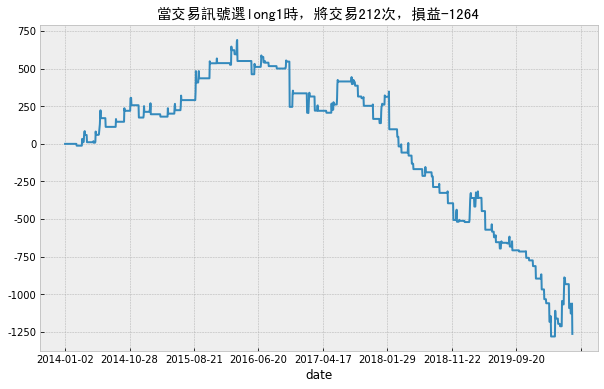

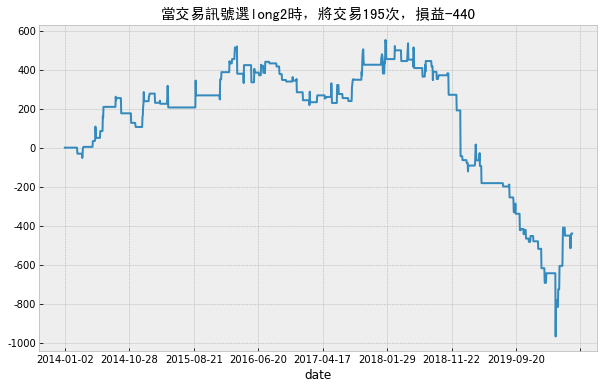

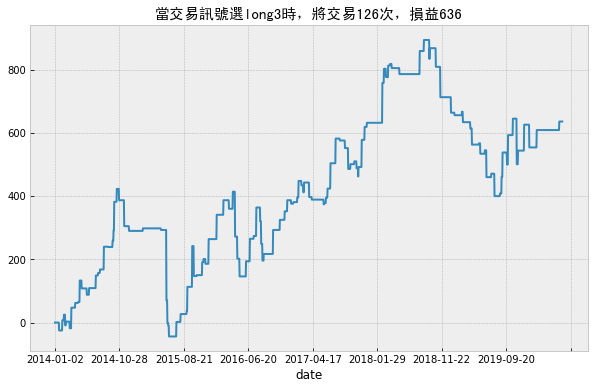

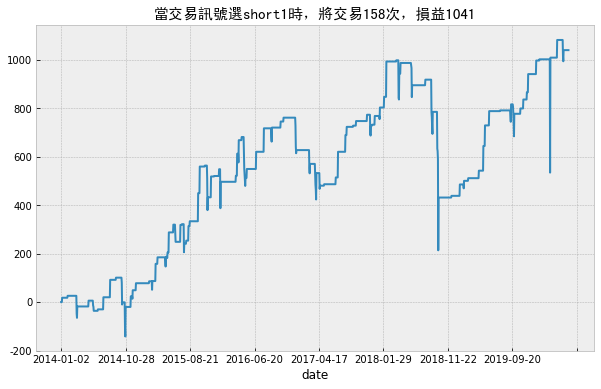

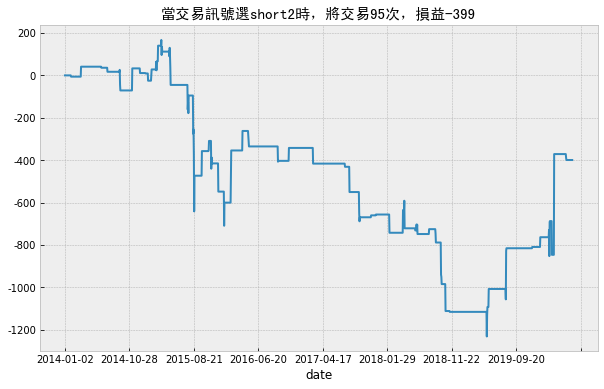

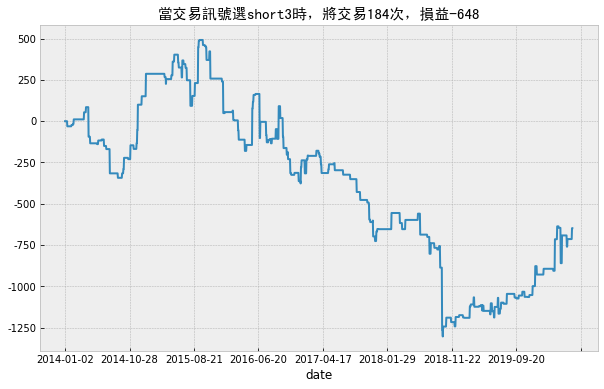

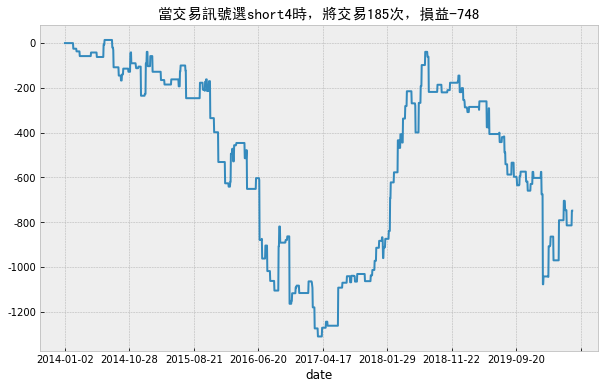

In [3]:
def backtest(i):    
    df['signal'] = df[i].shift() # NaN反正不是1，算pnl時自動忽略
    df['PnL'] = 0
    for i in range(len(df)):
        if df['signal'][i] == 1:
            df['PnL'][i] = df['Close'][i] - df['Open'][i] -4
    lots = len(df[df['signal'] == 1])   
    pnl = df['PnL'].sum()
    plt.figure()
    plt.title(f'當交易訊號選{j}時，將交易{lots}次，損益{pnl}',fontproperties= cht, fontsize=15)
    df['PnL'].cumsum().plot(figsize=(10,6))
    return

for j in df.columns[5:-1]:
    backtest(j)

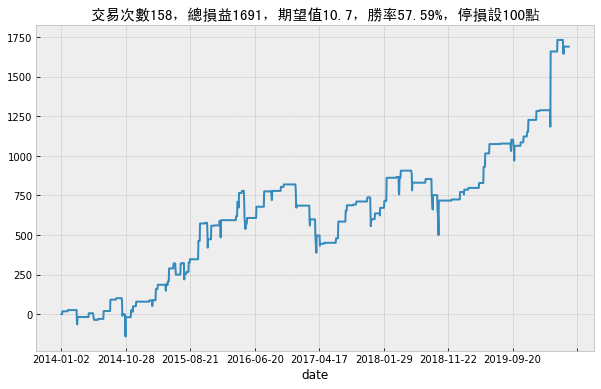

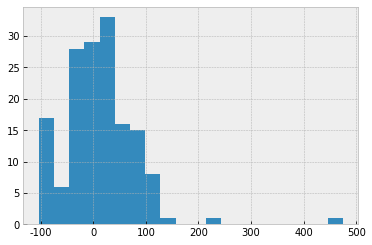

In [4]:
df['signal'] = df['short1'].shift()
df['PnL'] = 0
stp = 100
for i in range(len(df)):
    if df['signal'][i] == 1:
        if df['Low'][i] < df['Open'][i] - stp:
            df['PnL'][i] = -stp -4
        else:
            df['PnL'][i] = df['Close'][i] - df['Open'][i] -4
    else:continue

gain = len(df[df['PnL'] > 1])
pnl = df['PnL'].sum()
lots= len(df[df['signal'] == 1])

plt.title(f'交易次數{lots}，總損益{pnl}，期望值{round((pnl/lots),2)}，勝率{round((gain/lots)*100,2)}%，停損設{stp}點',fontproperties= cht, fontsize=15)
df['PnL'].cumsum().plot(figsize=(10,6))
plt.figure()
_ = plt.hist(df['PnL'][df['PnL']!=0] , bins= 20)